# Application: Face Blurring

<p>
In today's world, cameras and videos are everywhere and privacy has become a big concern, so much so that manual identification and annotation to preserve privacy are often not practical. In this application notebook we will demonstrate how to automatically identify faces in images using a deep learning model and then obfuscate them using various techniques to preserve privacy by obscuring the identity of the people in the images. This notebook will demonstrate various techniques using images, but this can easily be extended to videos based on the prior modules that covered video analysis. In this notebook we will use standard blurring, pixelation, and also incorporate the use of an elliptical mask to provide a better approximation to blurring the shape of a person's face.

The purpose of this notebook is to demonstrate three most common techniques which can be used for face blurring<br>
1.) Gaussian Blur (Rectangluar shape blur)<br>
2.) Pixelated (Rectangular shape blur)<br>
3.) Ellipse Blur (Gaussian Blur + Ellipse shape)<br>
4.) Combined: Elliptical, Blurred and Pixelated<br>
</p>

## Load packages and libraries

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
img = cv2.imread(r"C:\Users\SP.000\Pictures\Saved Pictures\vk_starter.jpg")

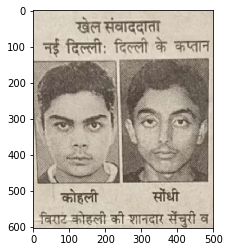

In [3]:
plt.imshow(img[:,:,::-1])

## Load DNN module

In [4]:
net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "res10_300x300_ssd_iter_140000_fp16.caffemodel")

### 1.) Gaussian Blur (Rectangluar shape blur)

In [5]:
def blur(face, factor=3):
    h, w = face.shape[:2]
    if(factor < 1): factor = 1#Maximum Blurring
    if(factor > 1): factor = 5#Minimum Blurring
    
    w_k = int(w/factor)
    h_k = int(h/factor)
    
    if(w_k % 2 == 0):
        w_k += 1
    if(h_k % 2 == 0):
        h_k += 1
    dst = cv2.GaussianBlur(src=face,ksize=(w_k,h_k),sigmaX=0,sigmaY=0)
    return dst

In [6]:
def face_blur_rect(image, net, factor=3, detection_threshold=0.9):
    img = image.copy()
    blob = cv2.dnn.blobFromImage(image=img,scalefactor=1,size=(300,300),mean=[104,117,123],swapRB=False,crop=False)
    net.setInput(blob)
    detections = net.forward()
    (h, w) = img.shape[:2]
    for i in detections[0][0]:
        if (i[2] >= detection_threshold):
            x1 = int(i[3] * w)
            y1 = int(i[4] * h)
            x2 = int(i[5] * w)
            y2 = int(i[6] * h)
            face = img[y1:y2, x1:x2]
            blurred_face = blur(face,factor=factor)
            img[y1:y2, x1:x2] = blurred_face
    return img

In [7]:
blurred = face_blur_rect(img, net, 2.5)

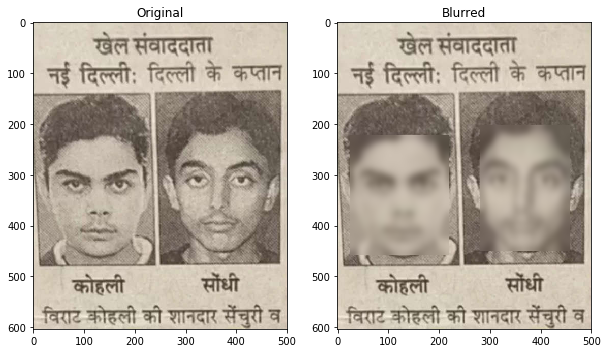

In [8]:
plt.figure(figsize=(10,10))
plt.subplot(121);plt.title("Original");plt.imshow(img[:,:,::-1]);
plt.subplot(122);plt.title("Blurred");plt.imshow(blurred[:,:,::-1])

### 2.) Pixelated (Rectangular shape blur)

In [9]:
def pixelate(roi, pixels):
    roi_h, roi_w = roi.shape[:2]
    if(roi_h > pixels and roi_w > pixels):
        roi_small = cv2.resize(roi,(pixels,pixels),cv2.INTER_LINEAR)
        roi_pixelated = cv2.resize(roi_small,(roi_w,roi_h),cv2.INTER_NEAREST)
    else:
        roi_pixelated = roi
    return roi_pixelated

In [10]:
def face_blur_pixelate(image, net, detection_threshold=0.9, pixels=10):
    img = image.copy()
    
    # Prepare image and perform inference.
    blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300), mean=[104, 117, 123])
    net.setInput(blob)
    detections = net.forward()
    
    h, w = img.shape[:2]
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > detection_threshold:
            
            # Extract the bounding box coordinates from the detection.
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")
            
            face = img[y1:y2, x1:x2]
            face = pixelate(face, pixels=pixels)
            img[y1:y2, x1:x2] = face
            
    return img

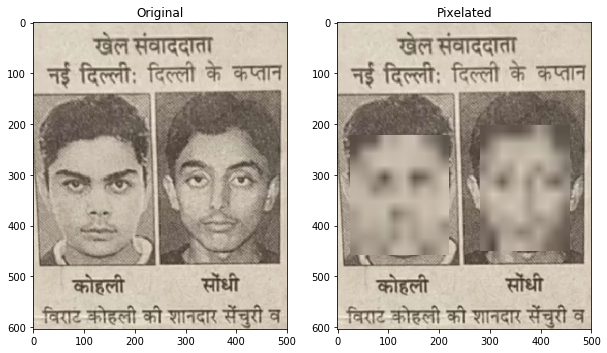

In [37]:
blurred_pixelated = face_blur_pixelate(img,net)
plt.figure(figsize=(10,10))
plt.subplot(121);plt.title("Original");plt.imshow(img[:,:,::-1]);
plt.subplot(122);plt.title("Pixelated");plt.imshow(blurred_pixelated[:,:,::-1])

### 3.) Ellipse Blur (Gaussian Blur + Ellipse shape)

In [33]:
def face_blur_ellipse(image, net, factor=3, detect_threshold=0.90, write_mask=False):
    
    img = image.copy()
    img_blur = img.copy()
    
    elliptical_mask = np.zeros(img.shape, dtype=img.dtype)
    
    # Prepare image and perform inference.
    blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300), mean=[104, 117, 123])
    net.setInput(blob)
    detections = net.forward()
    
    h, w = img.shape[:2]
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > detect_threshold:

            # Extract the bounding box coordinates from the detection.
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box

            # The face is defined by the bounding rectangle from the detection.
            face = img[int(y1):int(y2), int(x1):int(x2), :]
           
            # Blur the rectangular area defined by the bounding box.
            face = blur(face, factor=factor)

            # Copy the `blurred_face` to the blurred image.
            img_blur[int(y1):int(y2), int(x1):int(x2), :] = face
            
            # Specify the elliptical parameters directly from the bounding box coordinates.
            e_center = (x1 + (x2 - x1)/2, y1 + (y2 - y1)/2)
            e_size   = (x2 - x1, y2 - y1)
            e_angle  = 0.0
            
            # Create an elliptical mask. 
            elliptical_mask = cv2.ellipse(elliptical_mask, (e_center, e_size, e_angle), 
                                                      (255, 255, 255), -1, cv2.LINE_AA)  
            # Apply the elliptical mask
            np.putmask(img, elliptical_mask, img_blur)
            
    if write_mask:
        cv2.imwrite('elliptical_mask.jpg', elliptical_mask)

    return img

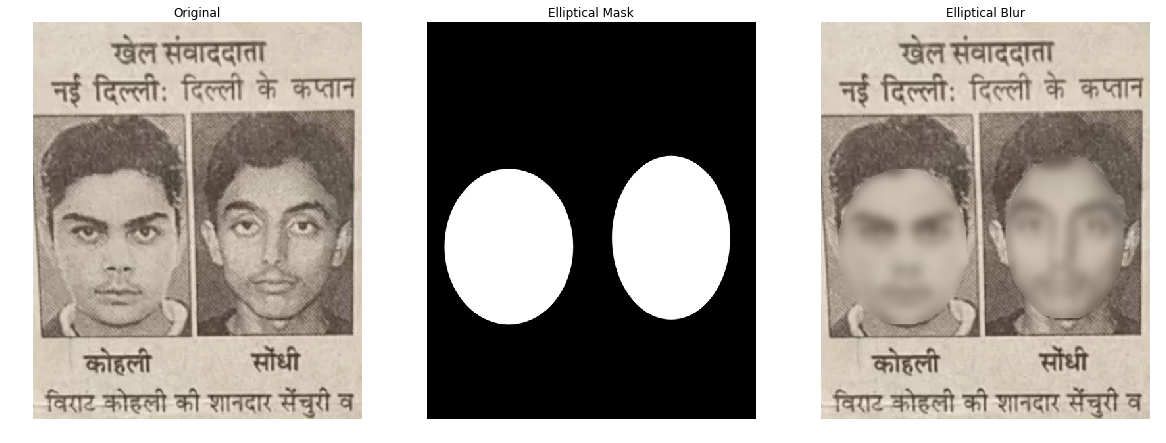

In [34]:
img1_ellipse = face_blur_ellipse(img, net, factor=2.5, write_mask=True)

mask = cv2.imread('elliptical_mask.jpg')
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.axis('off'); plt.imshow(img[:,:,::-1]);         plt.title('Original')
plt.subplot(1,3,2); plt.axis('off'); plt.imshow(mask);                   plt.title('Elliptical Mask')
plt.subplot(1,3,3); plt.axis('off'); plt.imshow(img1_ellipse[:,:,::-1]); plt.title('Elliptical Blur');

### 4.) Combined: Elliptical, Blurred and Pixelated

In [25]:
def face_blur_ellipse_pixelate(image, net, pixels, factor=3, detect_threshold=0.90, write_mask=False):
    
    img = image.copy()
    img_blur = img.copy()
    
    elliptical_mask = np.zeros(img.shape, dtype=img.dtype)
    
    # Prepare image and perform inference.
    blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300), mean=[104, 117, 123])
    net.setInput(blob)
    detections = net.forward()
    
    h, w = img.shape[:2]
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > detect_threshold:

            # Extract the bounding box coordinates from the detection.
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box

            # The face is defined by the bounding rectangle from the detection.
            face = img[int(y1):int(y2), int(x1):int(x2), :]
           
            # Blur the rectangular area defined by the bounding box.
            face = blur(face, factor=factor)

            # Copy the `blurred_face` to the blurred image.
            img_blur[int(y1):int(y2), int(x1):int(x2), :] = face
            
            face_to_pixelate = img_blur[int(y1):int(y2), int(x1):int(x2), :]

            face = pixelate(face_to_pixelate, pixels=pixels)
            
            img_blur[int(y1):int(y2), int(x1):int(x2), :] = face
            # Specify the elliptical parameters directly from the bounding box coordinates.
            e_center = (x1 + (x2 - x1)/2, y1 + (y2 - y1)/2)
            e_size   = (x2 - x1, y2 - y1)
            e_angle  = 0.0
            
            # Create an elliptical mask. 
            elliptical_mask = cv2.ellipse(elliptical_mask, (e_center, e_size, e_angle), 
                                                      (255, 255, 255), -1, cv2.LINE_AA)  
            # Apply the elliptical mask
            np.putmask(img, elliptical_mask, img_blur)
            
    if write_mask:
        cv2.imwrite('elliptical_mask.jpg', elliptical_mask)

    return img

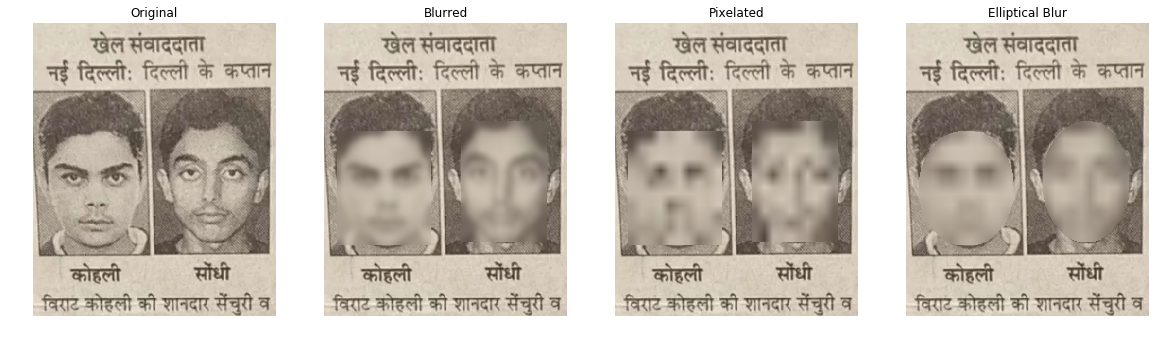

In [31]:
img_ellipse_blur_pixelate = face_blur_ellipse_pixelate(img, net, pixels=10, factor=2.5, write_mask=True)

mask = cv2.imread('elliptical_mask.jpg')
fig = plt.figure(figsize=(20,10))
plt.subplot(1,4,1); plt.axis('off'); plt.imshow(img[:,:,::-1]);        plt.title('Original')
plt.subplot(1,4,2); plt.axis('off'); plt.imshow(blurred[:,:,::-1]);    plt.title('Blurred')
plt.subplot(1,4,3); plt.axis('off'); plt.imshow(blurred_pixelated[:,:,::-1]);    plt.title('Pixelated')
plt.subplot(1,4,4); plt.axis('off'); plt.imshow(img_ellipse_blur_pixelate[:,:,::-1]); plt.title('Elliptical Blur');